In [1]:
import dill
import numpy as np
import haiku as hk
import jax.numpy as jnp
import jax
from typing import Callable, Iterable, Optional
import optax
from tqdm import trange
from matplotlib import pyplot as plt
import seaborn as sns
from jax.config import config
from sklearn.metrics import r2_score
import random
from haiku_custom_forward import _custom_forward_fn, schedule_lr, loss_fn, accuracy, update, output_size, activation
from plotVis import *

max_grad_norm = 0.1
n_epochs = 1000
lr = 1e-3
decay = 5e-3
batch_size = 1000
print(f'Layers: {output_size}')
print(f'Activation: {activation}')
config.update("jax_enable_x64", True)
dtype=jnp.float64

Layers: [100, 100, 100, 276]
Activation: <function leaky_relu at 0x7f4cc193bd90>


(89, 3)
(358, 276)


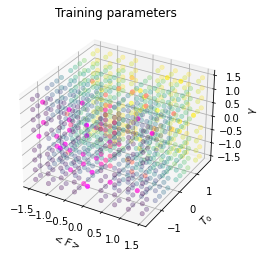

In [2]:
'''
Load Train and Test Data
'''
redshift = 5.4 #choose redshift from
num = '_training_768' 
test_num = '_test_89' 
vali_num = '_vali_358' 
# get the appropriate string and pathlength for chosen redshift
zs = np.array([5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0])
z_idx = np.argmin(np.abs(zs - redshift))
z_strings = ['z54', 'z55', 'z56', 'z57', 'z58', 'z59', 'z6']
z_string = z_strings[z_idx]
dir_lhs = '/home/zhenyujin/igm_emulator/igm_emulator/emulator/GRID/'

X = dill.load(open(dir_lhs + f'{z_string}_param{num}.p', 'rb')) # load normalized cosmological parameters from grab_models.py
X_test = dill.load(open(dir_lhs + f'{z_string}_param{test_num}.p', 'rb'))
X_vali = dill.load(open(dir_lhs + f'{z_string}_param{vali_num}.p', 'rb'))
meanX = X.mean(axis=0)
stdX = X.std(axis=0)
X_train = (X - meanX) / stdX
X_test = (X_test - meanX) / stdX
X_vali = (X_vali - meanX) / stdX
print(X_test.shape)

Y = dill.load(open(dir_lhs + f'{z_string}_model{num}.p', 'rb'))
Y_test = dill.load(open(dir_lhs + f'{z_string}_model{test_num}.p', 'rb'))
Y_vali = dill.load(open(dir_lhs + f'{z_string}_model{vali_num}.p', 'rb'))
meanY = Y.mean(axis=0)
stdY = Y.std(axis=0)
Y_train = (Y - meanY) / stdY
Y_test = (Y_test - meanY) / stdY
Y_vali = (Y_vali - meanY) / stdY
print(Y_vali.shape)

input_overplot(X_train,X_test)

In [3]:
custom_forward = hk.without_apply_rng(hk.transform(_custom_forward_fn))
init_params = custom_forward.init(rng=42, x=X_train)
preds = custom_forward.apply(params=init_params, x=X_train)
print(loss_fn(init_params,X_train,Y_train))

1.0387107462854461


In [4]:
n_samples = X_train.shape[0]
total_steps = n_epochs*(n_samples//batch_size) + n_epochs

optimizer = optax.chain(optax.clip_by_global_norm(max_grad_norm),
                        optax.adam(learning_rate=schedule_lr(lr,total_steps))
                        )
opt_state = optimizer.init(init_params)

/home/zhenyujin/igm_emulator/venv/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhenyujin/igm_emulator/venv/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhenyujin/igm_emulator/venv/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

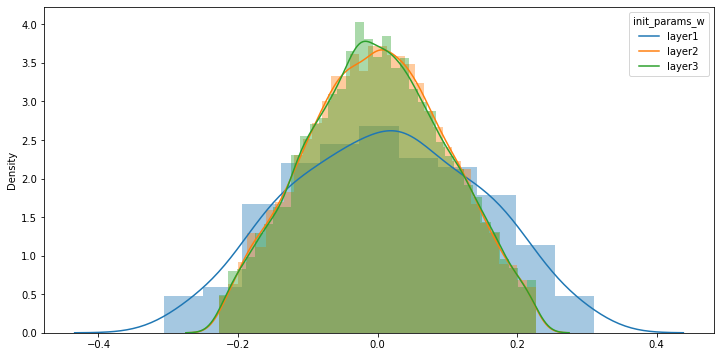

/home/zhenyujin/igm_emulator/venv/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhenyujin/igm_emulator/venv/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhenyujin/igm_emulator/venv/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

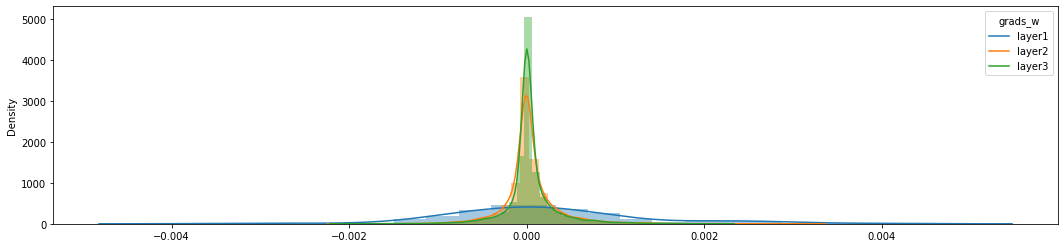

/home/zhenyujin/igm_emulator/venv/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhenyujin/igm_emulator/venv/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhenyujin/igm_emulator/venv/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

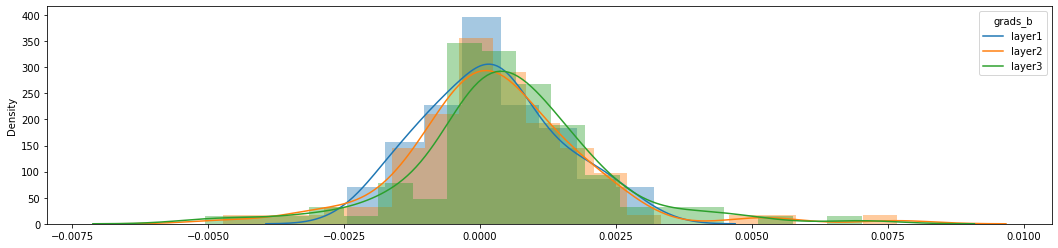

In [5]:
params_grads_distribution(loss_fn,init_params,X_train,Y_train)

  0%|          | 0/1000 [00:00<?, ?it/s]

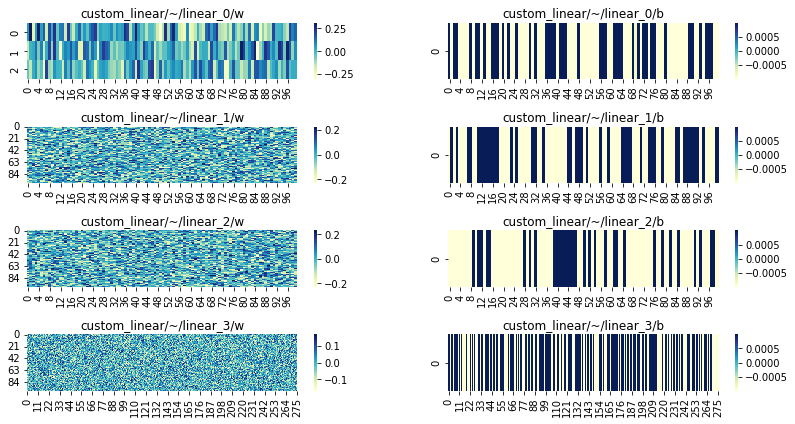

 10%|█         | 100/1000 [00:15<01:42,  8.75it/s, loss=0.03227391313809979]

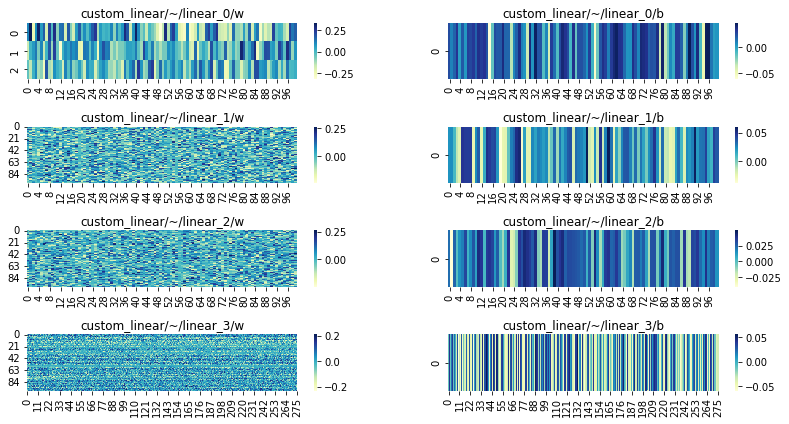

 20%|██        | 200/1000 [00:30<01:31,  8.75it/s, loss=0.022842993407135682]

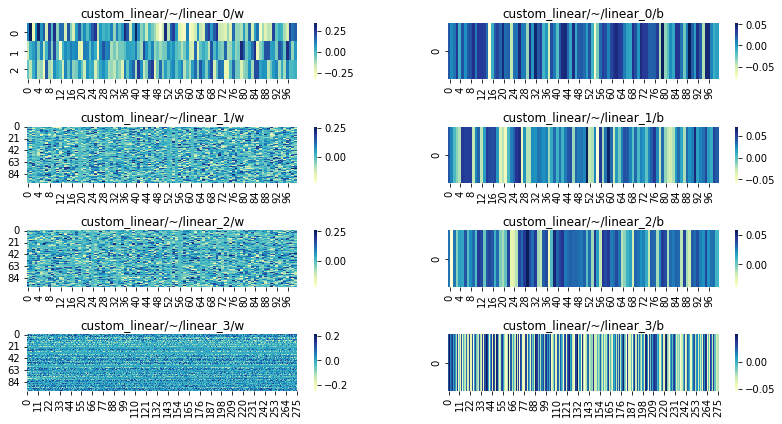

 30%|███       | 300/1000 [00:45<01:23,  8.38it/s, loss=0.022113107325197133]

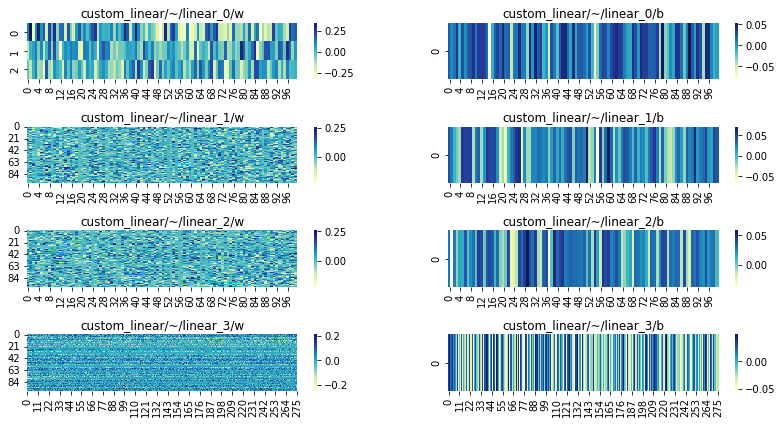

 40%|████      | 400/1000 [01:00<01:07,  8.92it/s, loss=0.021298766761800307]

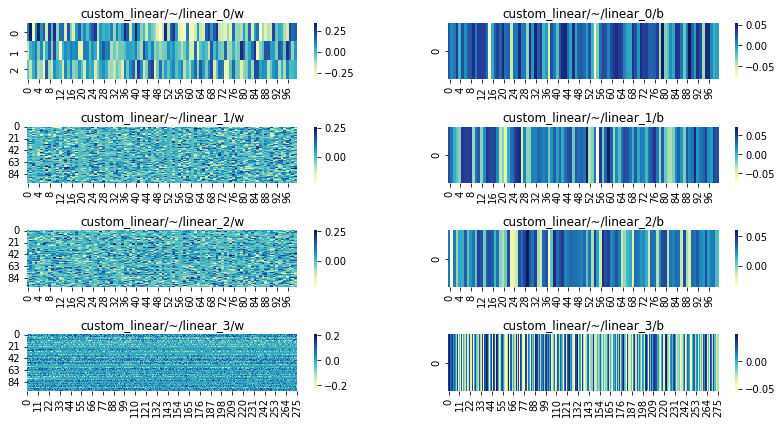

 50%|█████     | 500/1000 [01:14<00:54,  9.22it/s, loss=0.02120927077805557] 

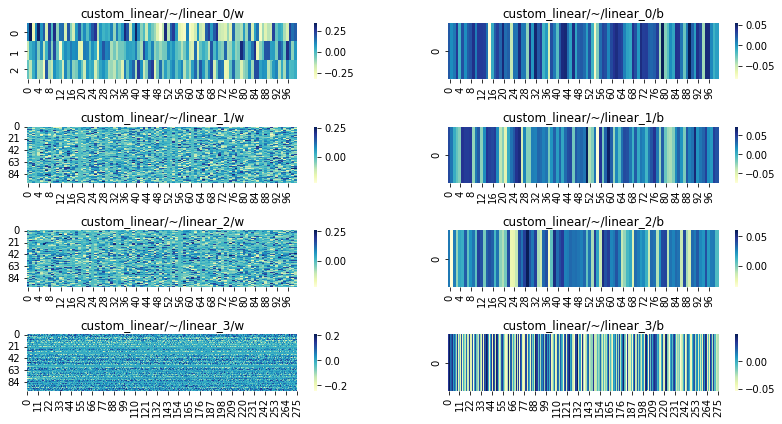

 60%|██████    | 600/1000 [01:29<00:45,  8.77it/s, loss=0.021110070162428825]

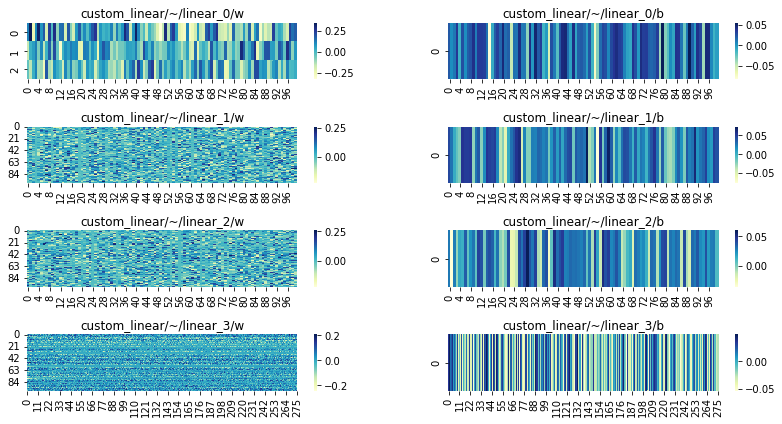

 70%|███████   | 700/1000 [01:43<00:34,  8.78it/s, loss=0.02109920448357068] 

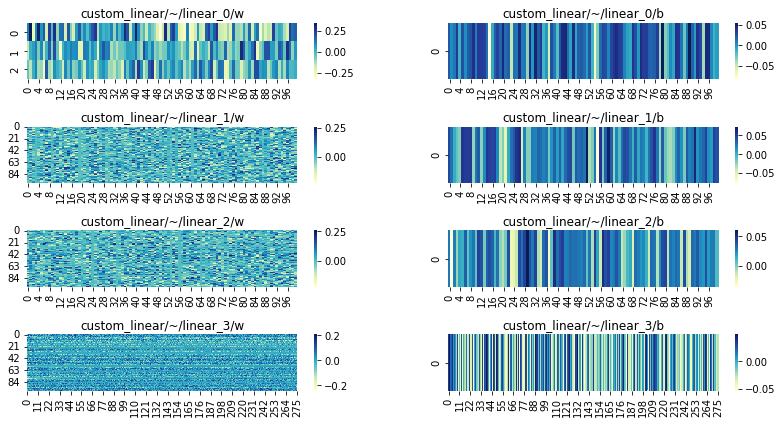

 80%|████████  | 800/1000 [01:58<00:22,  8.95it/s, loss=0.02108738918480819] 

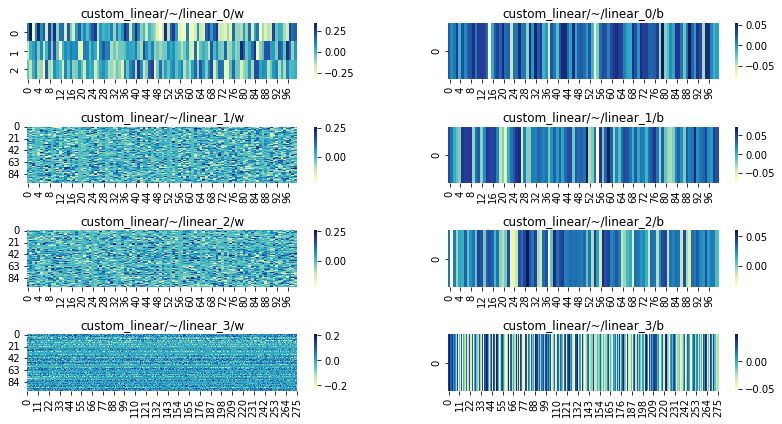

 90%|█████████ | 900/1000 [02:13<00:11,  8.80it/s, loss=0.02108611563238761] 

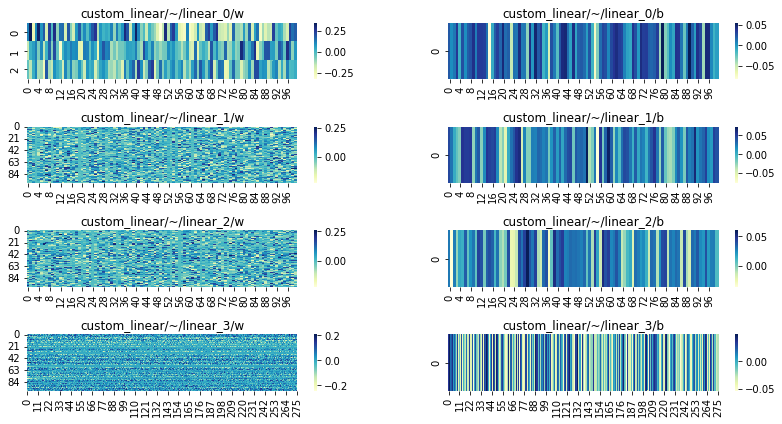

100%|██████████| 1000/1000 [02:26<00:00,  6.81it/s, loss=0.02108475132874976]


Reached max number of epochs in this batch. Validation loss =0.02108475132874976. Training loss =0.020992479520177132
Model saved.
early_stopping_counter: 0
accuracy: 0.0017276648786494365
Test Loss: 0.021080034685685606


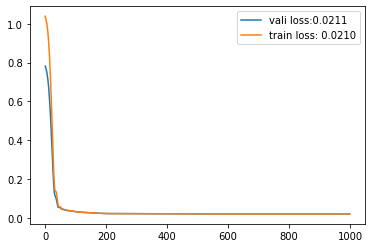

In [6]:
'''
Training Loop + Visualization of params
'''
best_loss = np.inf
validation_loss = []
training_loss = []
early_stopping_counter = 0
pv = 100
params = init_params

if __name__ == "__main__":
    with trange(n_epochs) as t:
        for step in t:
            # optimizing loss by update function
            params, opt_state, batch_loss, grads = update(params, opt_state, X_train, Y_train, optimizer)

            if step % 100 == 0:
                plot_params(params)

            # compute training & validation loss at the end of the epoch
            l = loss_fn(params, X_vali, Y_vali)
            training_loss.append(batch_loss)
            validation_loss.append(l)

            # update the progressbar
            t.set_postfix(loss=validation_loss[-1])

            # early stopping condition
            if l <= best_loss:
                best_loss = l
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
            if early_stopping_counter >= pv:
                break

    print(f'Reached max number of epochs in this batch. Validation loss ={best_loss}. Training loss ={batch_loss}')
    best_params = params
    print(f'Model saved.')
    print(f'early_stopping_counter: {early_stopping_counter}')
    print(f'accuracy: {jnp.mean(accuracy(params, X_test, Y_test, meanY, stdY))}')
    print(f'Test Loss: {loss_fn(params, X_test, Y_test)}')
    plt.plot(range(len(validation_loss)), validation_loss, label=f'vali loss:{best_loss:.4f}')  # plot validation loss
    plt.plot(range(len(training_loss)), training_loss, label=f'train loss:{batch_loss: .4f}')  # plot training loss
    plt.legend()

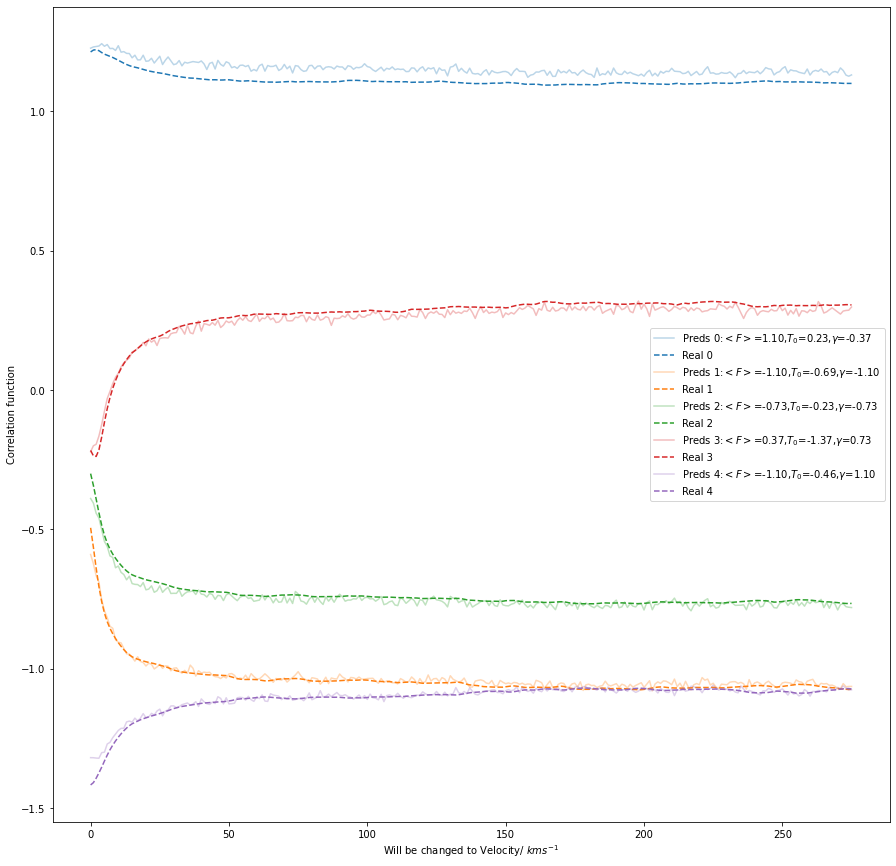

In [7]:
preds = custom_forward.apply(params=best_params, x=X_train)
train_overplot(preds, Y_train, X_train)

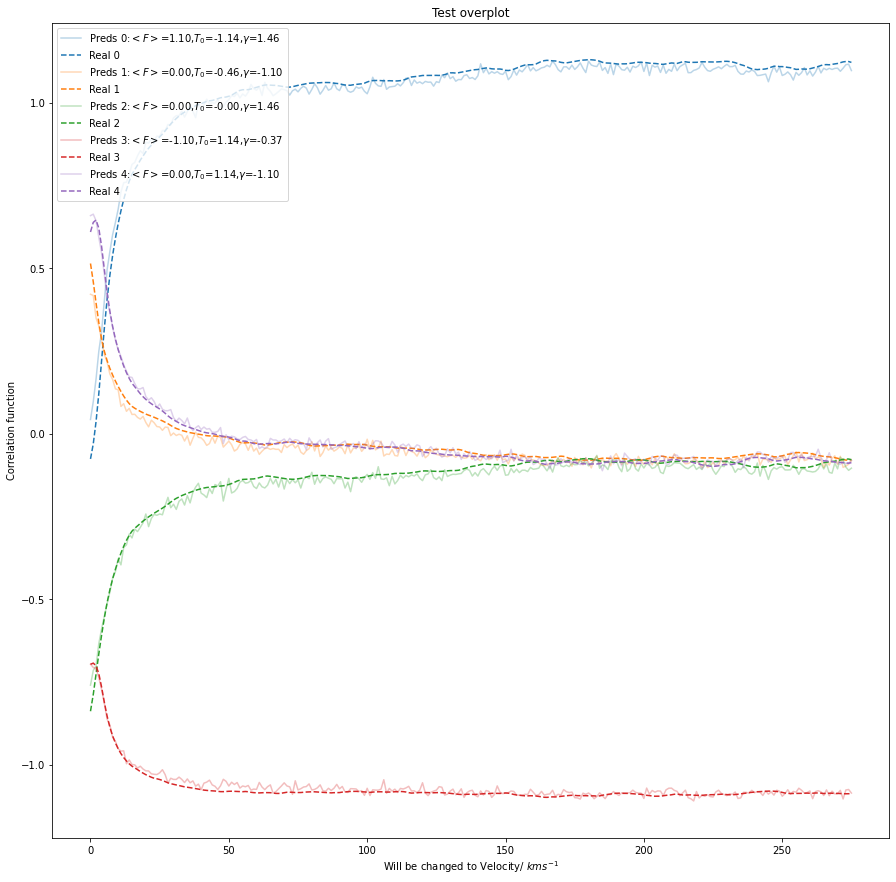

In [8]:
test_preds = custom_forward.apply(params, X_test)
test_loss = loss_fn(params, X_test, Y_test)
test_R2 = r2_score(test_preds.squeeze(), Y_test)

test_overplot(test_preds, Y_test, X_test)

Test MSE Loss: 0.021080034685685606

Test R^2 Score: 0.9990329140556483

accuracy: 0.17276648786494364


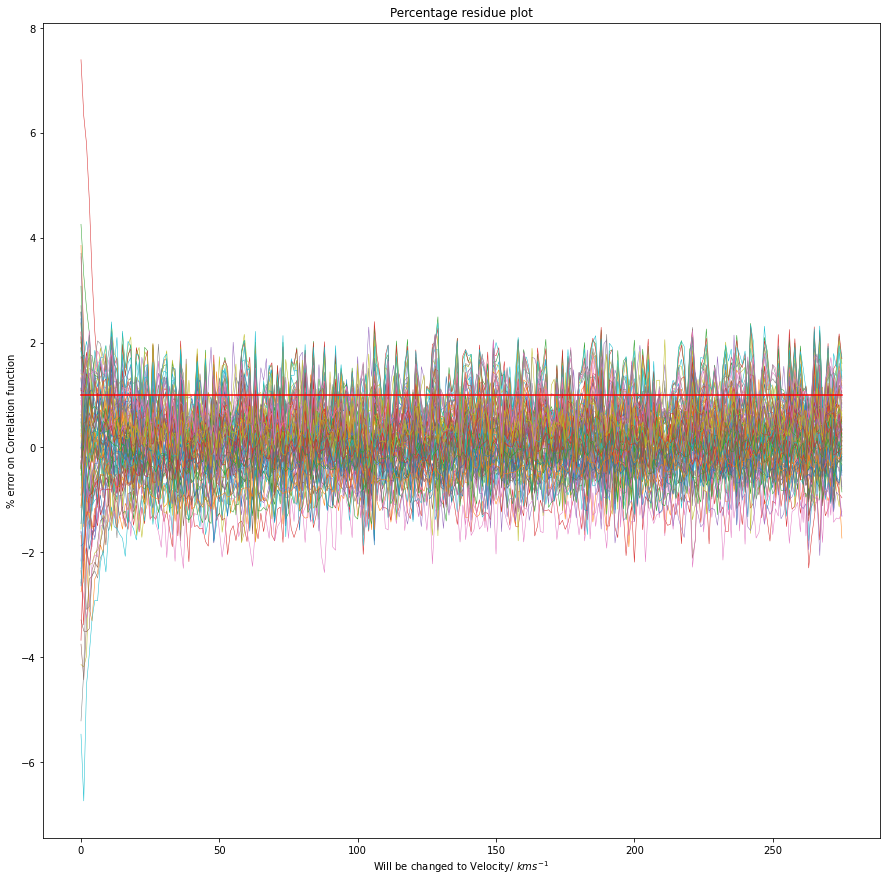

unlearned:(3,)


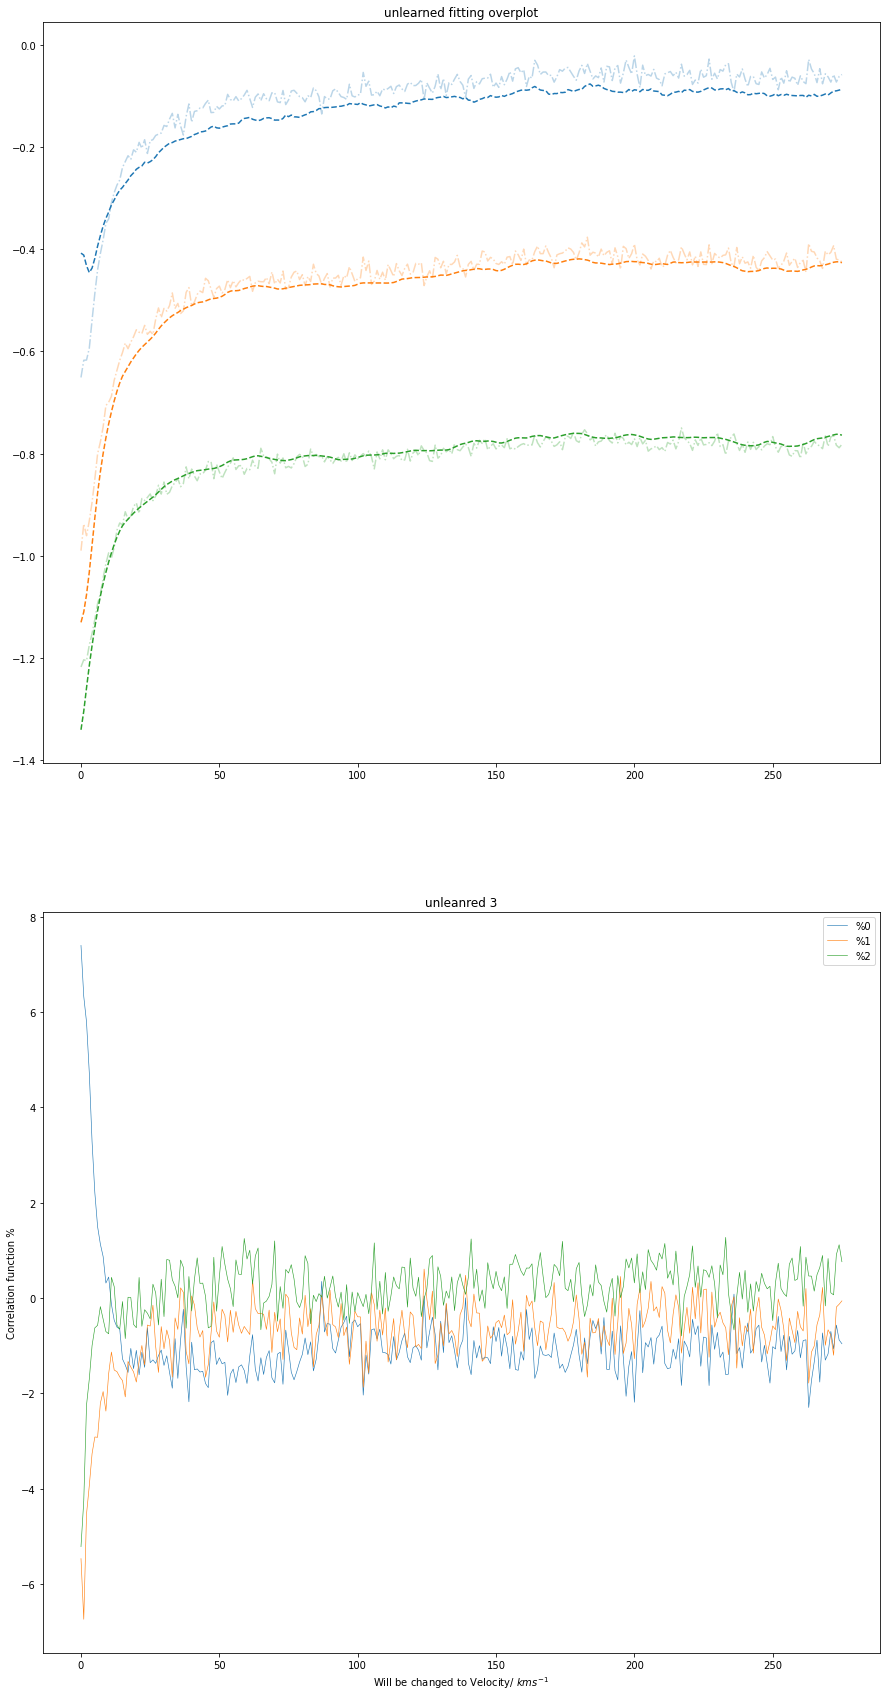

In [9]:
delta = np.asarray(accuracy(best_params, X_test, Y_test, meanY, stdY))
print("Test MSE Loss: {}\n".format(test_loss)) # Loss
print('Test R^2 Score: {}\n'.format(test_R2))  # R^2 score: ranging 0~1, 1 is good model
print(f'accuracy: {jnp.mean(delta)*100}')

plot_residue(delta)
bad_learned_plots(delta,X_test,Y_test,test_preds)

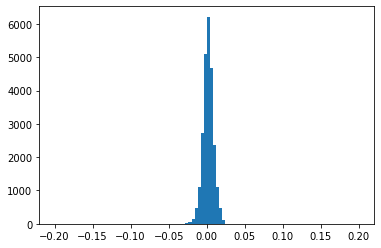

%mean: 0.17276648786494372; %std: 0.7031820783154553


In [10]:
plot_error_distribution(delta)